In [2]:
import pandas as pd
import thinkstats2 as ts2
import thinkplot as tp
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
%matplotlib inline

In [3]:
mta = pd.read_csv("Turnstile_Usage_Data__2015.csv")

In [4]:
mta.columns = map(str.lower, mta.columns)

In [5]:
mta.columns = ['c/a', 'unit', 'scp', 'station', 'line name', 'division', 'date',
       'time', 'description', 'entries', 'exits']

### Address
Create a column address which inclues the control area, remote unit, and subunit channel position. This is a unique identifier for each system tabulating entries and exits. 

In [6]:
mta["address"] = mta["c/a"]+"."+mta["unit"]+"."+mta["scp"]

In [7]:
mta["date"]=pd.to_datetime(mta.date, infer_datetime_format=True)
mta["time"]=pd.to_datetime(mta.time, format='%H:%M:%S').dt.time

In [8]:
mta = mta.drop_duplicates()
mta = mta.sort_values(["address","date","time","station"], ascending=[True, True, True, True])
mta = mta.reset_index(mta)
mta = mta.drop('index',1)

### Difference
Calculate the difference between one measurement by the MTA at a given position and the next to obtain the number of periodic entries and exits.

In [9]:
mta["shifted_entries"] = mta.entries.shift()
mta["shifted_exits"] = mta.exits.shift()
mta["period_entries"] = mta.entries - mta.shifted_entries
mta["period_exits"] = mta.exits - mta.shifted_exits
mta = mta.drop(['shifted_entries', 'shifted_exits'],1)

In [10]:
mta.to_csv("sortedturnstiledata2015withnegativesanderrors.csv")

Remove negative values and outliers that likely result from errors

In [11]:
mta1 = mta[(mta.period_entries>=0)&(mta.period_exits>=0)&(mta.period_entries<20000)&(mta.period_exits<20000)]

Check for null values and print the corresponding rows.

### Entries and Exits
Plot the histogram for the entries and exits.

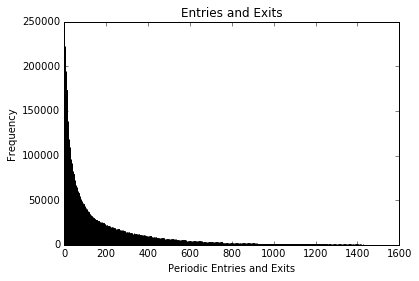

In [13]:
gr_than_zero = mta1[(mta1.period_entries>0)&(mta1.period_exits>0)]
plt.hist([gr_than_zero.period_entries, gr_than_zero.period_exits], bins=1000, range=(0,1500))
plt.title("Entries and Exits")
plt.xlabel("Periodic Entries and Exits")
plt.ylabel("Frequency")

In [269]:
mta1.to_csv("turnstile2015cleaned.csv")

There was a chunk of missing data for about 8 days that was all dumped at once on the 14th of November. If this day is included when average entries and exits, it could mess up the values. Fortunately, there was no precipitation on November 14, so removing it shouldn't severely impact the ability to understand the influence of precipitation on traffic. A similar set of outliers exists on November 28. 

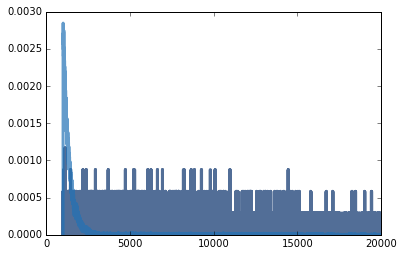

In [15]:
nov_14 = mta1[(mta1.date=='2015-11-14')&(mta1.period_entries>1000)].period_entries
everything = mta1[mta1.period_entries>1000].period_entries
nov_14_pmf = ts2.Pmf(nov_14, label='nov_14')
everything_pmf = ts2.Pmf(everything, 'actual')

tp.Pmf(nov_14_pmf, width=1)
tp.Pmf(everything_pmf, width=1)

In [16]:
mta1 = mta1[(mta1.date!="2015-11-14")&(mta1.date!="2015-01-01")&(mta1.date!="2015-11-28")]

In [17]:
wxd = pd.read_csv("daily_precipitation_data_2015.csv")

In [18]:
wxd['date'] = pd.to_datetime(wxd.date, format="%Y%m%d")

In [19]:
merged = mta1.merge(right=wxd, left_on="date", right_on="date", how='inner')
merged = merged.drop(['c/a', 'unit', 'scp', 'line name', 'division'], axis=1)

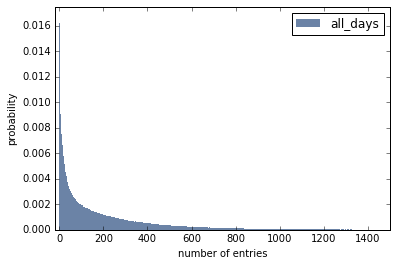

C:\Users\J.X\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


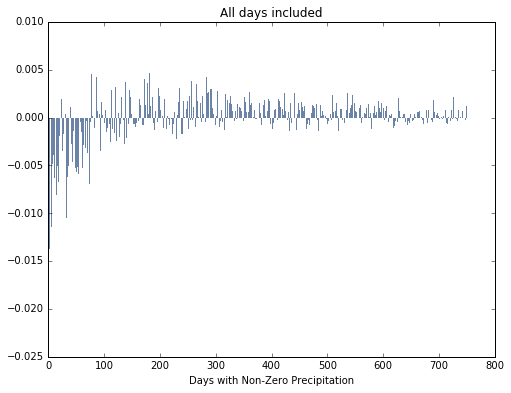

In [113]:
#exclude 0, because the difference is so large that it obscures other differences in the frame.
all_entries = merged[merged.period_entries>=0].period_entries
rain_days = merged[(merged.period_entries>=0)&(merged.prcp>0)].period_entries
all_entries_pmf = ts2.Pmf(all_entries, label='all_days')
rain_days_pmf = ts2.Pmf(rain_days, 'any_rain')

tp.Hist(all_entries_pmf, width=1)
tp.Show(label='Subway Entries', ylabel='probability', xlabel='number of entries', axis=[-20, 1500, 0, 0.0175])

entries = range(1, 750)
diffs = []
for entry in entries:
    p1 = all_entries_pmf.Prob(entry)
    p2 = rain_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

tp.Bar(entries, diffs)
tp.Show(title="All days included", xlabel="Days with Non-Zero Precipitation")

In [ ]:
#exclude 0, because the difference is so large that it obscures other differences in the frame.
all_entries = merged[merged.period_entries>=0].period_entries
rain_days = merged[(merged.period_entries>=0)&(merged.prcp>0)].period_entries
all_entries_pmf = ts2.Pmf(all_entries, label='any_weather')
rain_days_pmf = ts2.Pmf(rain_days, 'any_rain')

tp.Hist(all_entries_pmf, width=1)
tp.Show(label='Subway Entries', ylabel='probability', xlabel='number of entries', axis=[-20, 1500, 0, 0.0175])

entries = range(1, 750)
diffs = []
for entry in entries:
    p1 = all_entries_pmf.Prob(entry)
    p2 = rain_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

tp.Bar(entries, diffs)
tp.Show(title="All days included", xlabel="Days with Non-Zero Precipitation")

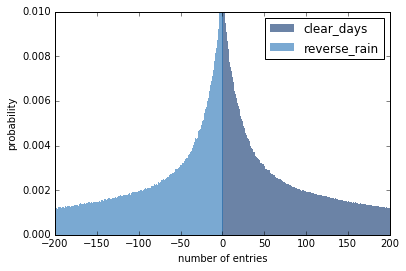

C:\Users\J.X\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


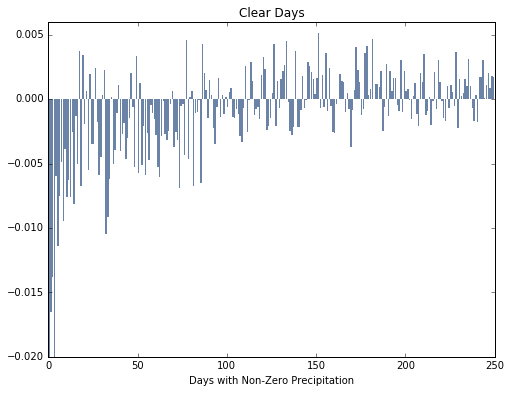

In [115]:
clear_days = merged[merged.prcp==0].period_entries
reversed_rain_days = merged[merged.prcp>0].period_entries*-1
rain_days = merged[merged.prcp>0].period_entries
clear_days_pmf = ts2.Pmf(all_entries, label='clear_days')
reversed_rain_days_pmf = ts2.Pmf(reversed_rain_days, 'reverse_rain')
rain_days_pmf = ts2.Pmf(rain_days, 'any_rain')

tp.Hist(clear_days_pmf, width=1)
tp.Hist(reversed_rain_days_pmf, width=1)
tp.Show(ylabel='probability', xlabel='number of entries', axis=[-200, 200, 0, 0.01])

#exclude 0, because the difference is so large that it obscures other differences in the frame.
entries = range(0, 750)
diffs = []
for entry in entries:
    p1 = clear_days_pmf.Prob(entry)
    p2 = rain_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

tp.Bar(entries, diffs)
tp.Show(title="Clear Days", xlabel="Days with Non-Zero Precipitation", axis=[0, 250, -0.02, 0.006])

In [51]:
clear_mean = merged[merged.prcp==0].period_entries.mean()
any_rain_mean = merged[merged.prcp>0].period_entries.mean()
rain_mean25 = merged[merged.prcp>0.25].period_entries.mean()
rain_mean50 = merged[merged.prcp>0.50].period_entries.mean()
diff = clear_mean - any_rain_mean
print("Clear mean is equal to: ", clear_mean,".")
print("The mean with any rain is equal to: ", any_rain_mean,".")
print("The mean with more than 0.25 inches is equal to: ", rain_mean25,".")
print("The mean with more than 0.5 inches is equal to: ", rain_mean50,".")

Clear mean is equal to:  189.38892803973252 .
The mean with any rain is equal to:  183.14521334826426 .
The mean with more than 0.25 inches is equal to:  175.7563817230634 .
The mean with more than 0.5 inches is equal to:  173.65569256225595 .


[0, 2.25, 0, 150]

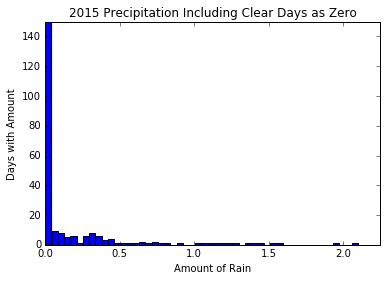

In [48]:
weather2015 = wxd[wxd.date<"20160101"].prcp
plt.hist(weather2015, bins=50)
plt.title("2015 Precipitation Including Clear Days as Zero")
plt.xlabel("Amount of Rain")
plt.ylabel("Days with Amount")
plt.axis([0, 2.25, 0, 150])

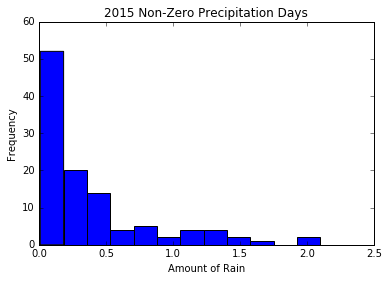

In [41]:
any_rain = wxd[(wxd.prcp>0)&(wxd.date<"20160101")].prcp
plt.hist(any_rain, bins=12)
plt.title("2015 Non-Zero Precipitation Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

### Mean Entries Against Rainfall
Populate a date frame with all the unique measurements of rainfall in a given data and the corresponding mean entries and exits per period for the corresponding day or days. 

Plot a scatter graph with the mean entries and exits via the measured precipitation.

In [53]:
cal = pd.read_csv("calendar.csv")
cal['date'] = pd.to_datetime(cal.date, format="%Y-%m-%d")
merged = merged.merge(cal, left_on="date", right_on="date")
work_days = merged[(merged.weekday==1)&(merged.holiday==0)]
play_days = merged[(merged.weekday==0)|(merged.holiday==1)]

In [77]:
rain_df = pd.read_csv("unique_rain.csv")
work_rain_df = pd.read_csv("work_rain.csv")
play_rain_df = pd.read_csv("play_rain.csv")

When means for all days are calculated:

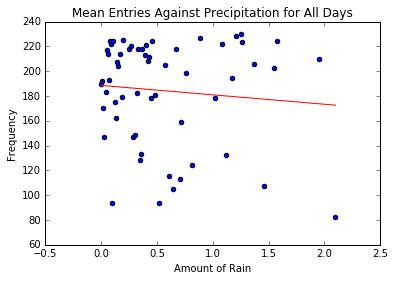

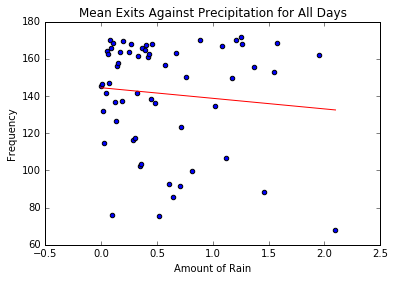

In [79]:
for i in range(len(rain_df.index)):
        value = rain_df.measurement[i]
        rain_df.mean_entries[i] = merged[merged.prcp==value].period_entries.mean()
        rain_df.mean_exits[i] = merged[merged.prcp==value].period_exits.mean()

x = rain_df.measurement
y = rain_df.mean_entries

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Entries Against Precipitation for All Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

x = rain_df.measurement
y = rain_df.mean_exits

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Exits Against Precipitation for All Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

In [57]:
print(sum(merged.period_exits))
print(sum(merged.period_entries))

1341104023.0
1749952898.0


When the means are only calculated for work days (not weekends or federal holidays):

C:\Users\J.X\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\J.X\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


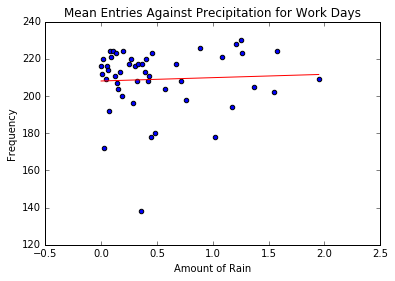

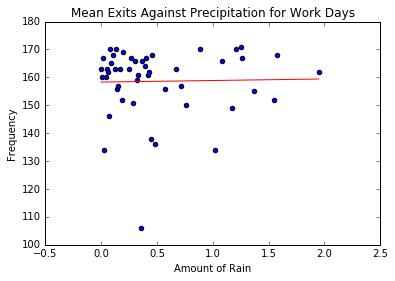

In [81]:
for i in range(len(work_rain_df.index)):
        value = work_rain_df.measurement[i]
        work_rain_df.mean_entries[i] = work_days[work_days.prcp==value].period_entries.mean()
        work_rain_df.mean_exits[i] = work_days[work_days.prcp==value].period_exits.mean()

x = work_rain_df.measurement
y = work_rain_df.mean_entries

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Entries Against Precipitation for Work Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

x = work_rain_df.measurement
y = work_rain_df.mean_exits

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Exits Against Precipitation for Work Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

For work days (neither holiday or weekend), it seems like the trendline stays exactly flat, suggesting that demand for MTA is a lot less elastic against the weather. This makes sense if most people who use the MTA on work days appreciate less choice in their decision to abstain.

When the means are calculated for only federal holidays and weekends:

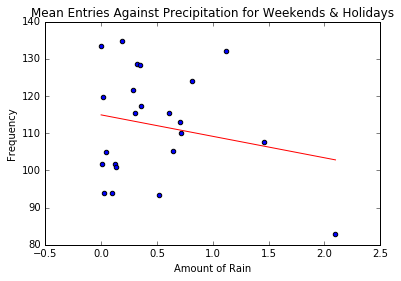

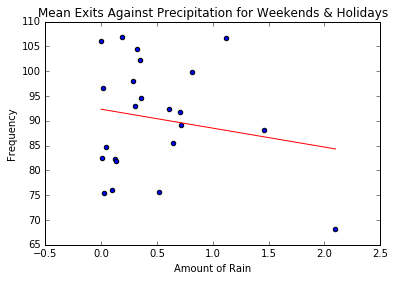

In [63]:
for i in range(len(play_rain_df.index)):
        value = play_rain_df.measurement[i]
        play_rain_df.mean_entries.loc[i] = play_days[play_days.prcp==value].period_entries.mean()
        play_rain_df.mean_exits.loc[i] = play_days[play_days.prcp==value].period_exits.mean()

x = play_rain_df.measurement
y = play_rain_df.mean_entries

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Entries Against Precipitation for Weekends & Holidays")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

x = play_rain_df.measurement
y = play_rain_df.mean_exits

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Exits Against Precipitation for Weekends & Holidays")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

C:\Users\J.X\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


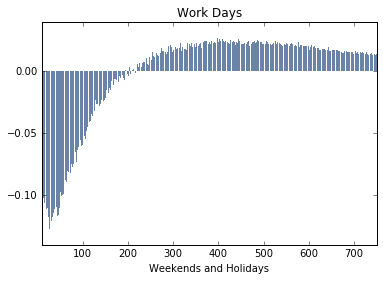

In [87]:
workdays_pmf = ts2.Pmf(work_days.period_entries)
play_days_pmf = ts2.Pmf(play_days.period_entries)

#exclude 0, because the difference is so large that it obscures other differences in the frame.
entries = range(10, 750)
diffs = []
for entry in entries:
    p1 = workdays_pmf.Prob(entry)
    p2 = play_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

tp.Bar(entries, diffs)
tp.Show(title="Work Days", xlabel="Weekends and Holidays", axis=[10, 750, -0.14, 0.04])